In [16]:
import pandas as pd
from pandasql import sqldf
import boto3
import json
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import os
from geopy.distance import distance
import numpy as np
from sklearn.preprocessing import Normalizer
from keras import models, layers
from sklearn.model_selection import train_test_split
%run '../extra_fns.ipynb'

In [2]:
with open('../config.json') as json_data:
    config = json.load(json_data)

In [3]:
s3 = boto3.client(
    's3',
    aws_access_key_id=config['boto']['aws_access_key_id'],
    aws_secret_access_key=config['boto']['aws_secret_access_key']
)

In [4]:
model_dir = 'trained_models'
try:
    os.makedirs(model_dir)
except Exception as e:
    print(e)

[Errno 17] File exists: 'trained_models'


In [5]:
callbacks = [
    EarlyStopping(monitor='val_mean_absolute_error', patience=1),
    ModelCheckpoint(filepath=model_dir + '/basic_model.h5', monitor='val_loss', save_best_only=True)
]

In [6]:
data_dir = 'data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
train_file = data_dir + '/train.csv'
test_file = data_dir + '/test.csv'

# s3.upload_file(src_file, boto_config['buckets']['kaggle'], src_file)
# s3.upload_file(src_file_cleaned, boto_config['buckets']['kaggle'], src_file_cleaned)

# s3.download_file(boto_config['buckets']['kaggle'], src_file, src_file)
# s3.download_file(boto_config['buckets']['kaggle'], src_file_cleaned, src_file_cleaned)

# train = pd.read_csv(train_file)
# test = pd.read_csv(test_file)

In [7]:
# train['distance'] = train.apply(lambda row : int(distance(
#     (row['pickup_latitude'], row['pickup_longitude']),
#     (row['dropoff_latitude'], row['dropoff_longitude'])).m), axis=1)

# train.pickup_datetime = pd.to_datetime(train.pickup_datetime)

# train['pickup_monthday'] = train.pickup_datetime.dt.day
# train['pickup_weekday'] = train.pickup_datetime.dt.weekday
# train['pickup_hour'] = train.pickup_datetime.dt.hour

In [8]:
# test['distance'] = test.apply(lambda row : int(distance(
#     (row['pickup_latitude'], row['pickup_longitude']),
#     (row['dropoff_latitude'], row['dropoff_longitude'])).m), axis=1)

# test.pickup_datetime = pd.to_datetime(test.pickup_datetime)

# test['pickup_monthday'] = test.pickup_datetime.dt.day
# test['pickup_weekday'] = test.pickup_datetime.dt.weekday
# test['pickup_hour'] = test.pickup_datetime.dt.hour

In [9]:
# train.to_csv('./data/train-clean.csv')
# test.to_csv('./data/test-clean.csv')

train = pd.read_csv('./data/train-clean.csv')
test = pd.read_csv('./data/test-clean.csv')

In [10]:
y_train = np.array(train.trip_duration)
X_train = np.array(train.loc[:, ['passenger_count', 'distance', 'pickup_monthday', 'pickup_weekday', 'pickup_hour']])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

X_test = np.array(test.loc[:, ['passenger_count', 'distance', 'pickup_monthday', 'pickup_weekday', 'pickup_hour']])

In [11]:
nml = Normalizer()

In [12]:
X_train = nml.fit_transform(X_train)
X_val = nml.transform(X_val)
X_test = nml.transform(X_test)

In [13]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1))

model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

model.summary()

history = model.fit(X_train, 
                    y_train, 
                    epochs=20, 
                    batch_size=512,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               768       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 11,649
Trainable params: 11,649
Non-trainable params: 0
_________________________________________________________________
Train on 1166915 samples, validate on 291729 samples
Epoch 1/20
1166915/1166915 [==============================] - 5s 4us/step - loss: 281

Min Val Absolute Error 455.3251042544632 on Epoch 2


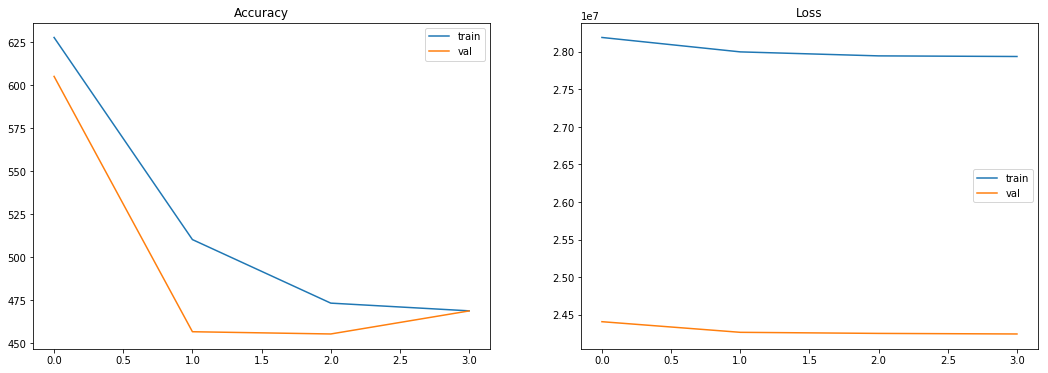

In [14]:
results = history.history
epochs = history.epoch

print('Min Val Absolute Error {0} on Epoch {1}'.format(np.min(results['val_mean_absolute_error']), np.argmin(results['val_mean_absolute_error'])))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))

ax1.plot(epochs, results['mean_absolute_error'], label='train')
ax1.plot(epochs, results['val_mean_absolute_error'], label='val')
ax1.set_title('Accuracy')
# ax1.set_ylim([0, 1])
ax1.legend()

ax2.plot(epochs, results['loss'], label='train')
ax2.plot(epochs, results['val_loss'], label='val')
ax2.set_title('Loss')
ax2.legend()

plt.show()

In [17]:
model = models.load_model(model_dir + '/basic_model.h5')

In [24]:
predictions = model.predict(X_test).astype(int)

In [29]:
subs = pd.DataFrame()
subs['id'] = test.id
subs['trip_duration'] = predictions

In [31]:
subs.to_csv(data_dir + '/subs.csv', index=False)